# Data for Good: predicting suicidal behavior likelihood among Reddit users using Deep Learning (Part 2)

*Deep Learning and Reinforcement Learning (part of IBM Machine Learning Professional Certificate) - Course Project.*

>*No one is useless in this world who lightens the burdens of another.*  
― **Charles Dickens**

<img src='https://www.discover-norway.no/upload/images/-development/header/desktop/kul_munch/edvard%20munch%20the%20scream%201893_munchmmuseet.jpg'></img>

## Table of contents (Part 2)
5. [Model Development: Recurrent Neural Networks](#model)  
  5.2. [Using Pre-trained Word Embeddings: GloVe (Global Vectors for Word Representation)](#glove)

*Import the training data, the testing data, and the vocabulary word index from the 1st part of the project.*

In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
x_train_pad = pd.read_csv('x_train_pad.csv', index_col=False).values
x_test_pad = pd.read_csv('x_test_pad.csv', index_col=False).values
y_train = pd.read_csv('y_train.csv', index_col=False)
y_test = pd.read_csv('y_test.csv', index_col=False)

In [3]:
with open('word_index.pkl', 'rb') as f:
    word_index = pickle.load(f)

## 5. Model Development: Recurrent Neural Networks <a name= 'model'></a>

In [4]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Embedding
from keras.callbacks import EarlyStopping
from keras import optimizers
from numpy.random import seed
import tensorflow as tf
import matplotlib.pyplot as plt

### 5.2 Using Pre-trained Word Embeddings: GloVe (Global Vectors for Word Representation) <a name=glove></a>

**GloVe** is an unsupervised learning algorithm for obtaining vector representations for words, developed as an open-source project at Stanford University. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. GloVe uses several dimensions for the word vectors; the embeddings I am using contains 300-dimensional vectors for 400,000 words.  
For more information on GloVe, check this link: <a href='https://nlp.stanford.edu/projects/glove/'>**GloVe: Global Vectors for Word Representation**</a>.

In [5]:
# load the whole GloVe embedding into memory
embeddings_index = dict()
f = open(r'glove.6B\glove.6B.300d.txt', encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded {} word vectors.'.format(f'{len(embeddings_index):,}'))

Loaded 400,000 word vectors.


In [6]:
# create a weight matrix, with the GloVe Vector Representation, for the words in the training set
embedding_matrix = np.zeros((len(word_index)+1, 300))
hits = 0
misses = 0

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted {} words ({} misses)".format(f'{hits:,}', f'{misses:,}'))

Converted 14,072 words (1,682 misses)


We have word vectors for 14,072 words in our training vocabulary. The remaining 1,682 words, which weren't found in the word vectors from GloVe, are assigned to a unique vector of all zeros.

The model architecture is the same as the first model. The only difference is that, this time, we won't train the word embeddings from scratch but we'll use the GloVe pre-trained emebeddings.  

In [7]:
seed(42)
tf.random.set_seed(42)

#let's build a second model without training the Embedding layer weights, but using the pre-trained GloVe Word Embeddings
rnn_glove = Sequential()

#Using Glove pre-trained embeddings
rnn_glove.add(Embedding(len(word_index.items())+1, output_dim=300, weights=[embedding_matrix], trainable=False))

# Add the RNN layer
rnn_glove.add(SimpleRNN(units=150, activation='tanh', input_shape=x_train_pad.shape[1:]))
# Add the final output layer
rnn_glove.add(Dense(1, activation='sigmoid'))
# Compile the model
adam = optimizers.Adam(learning_rate=0.001)
rnn_glove.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#Let's check the model architecture
rnn_glove.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         4726500   
                                                                 
 simple_rnn (SimpleRNN)      (None, 150)               67650     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 4,794,301
Trainable params: 67,801
Non-trainable params: 4,726,500
_________________________________________________________________


The total number of parameters is exactly the same of the first model (4,794,301), however **4,726,500 parameters are non trainable.**  
Since we are not learning our own word embeddings, the Embedding layer this time won't have to learn how to represent the words; we'll use instead the word representations from GloVe algorithm. That's why the 4,726,500 parameters of the embeddings layers are non-trainable: they have already been trained.  
Therefore, the model will have to train and learn "only" 67,801 parameters (67,650 for the Recurrent Neural Network section, and 151 for the final dense layer).  

To be consistent and compare model's performance based on 1 variable only (the word embeddings), I'll use the same **Mini Batch Gradient Descent** strategy of the first model:
- batch size: 16 observations
- iterations: 25
- epochs: 25
- data shuffle: yes

In [8]:
hist=rnn_glove.fit(x_train_pad, y_train, batch_size=16, epochs=25, shuffle=True, validation_data=(x_test_pad, y_test))

Epoch 1/25
25/25 [==============================] - 4s 88ms/step - loss: 0.7484 - accuracy: 0.5300 - val_loss: 0.7516 - val_accuracy: 0.5000
Epoch 2/25
25/25 [==============================] - 1s 52ms/step - loss: 0.4578 - accuracy: 0.8300 - val_loss: 0.8610 - val_accuracy: 0.4700
Epoch 3/25
25/25 [==============================] - 1s 55ms/step - loss: 0.2688 - accuracy: 0.9350 - val_loss: 0.8692 - val_accuracy: 0.5100
Epoch 4/25
25/25 [==============================] - 1s 48ms/step - loss: 0.1399 - accuracy: 0.9750 - val_loss: 1.0139 - val_accuracy: 0.5400
Epoch 5/25
25/25 [==============================] - 1s 50ms/step - loss: 0.0569 - accuracy: 1.0000 - val_loss: 1.2222 - val_accuracy: 0.5400
Epoch 6/25
25/25 [==============================] - 1s 43ms/step - loss: 0.0398 - accuracy: 0.9950 - val_loss: 1.4483 - val_accuracy: 0.5200
Epoch 7/25
25/25 [==============================] - 1s 43ms/step - loss: 0.0847 - accuracy: 0.9775 - val_loss: 1.1753 - val_accuracy: 0.4800
Epoch 8/25
25

In [9]:
print("Best Accuracy achieved on validation data:", round(max(hist.history['val_accuracy']),2))

Best Accuracy achieved on validation data: 0.64


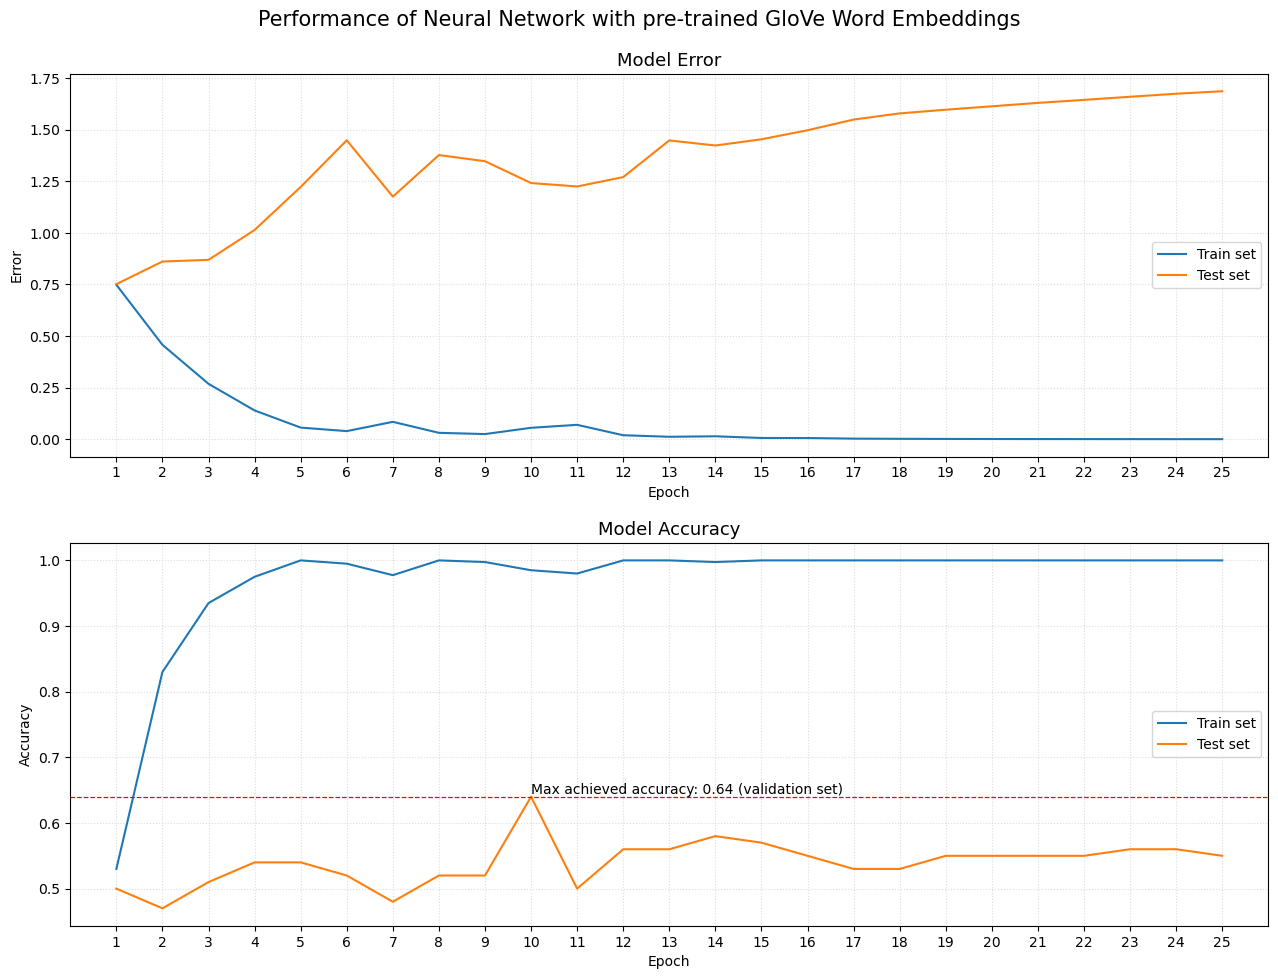

In [12]:
fig = plt.figure(figsize=(13,10))
loss = fig.add_subplot(2,1,1) 
accuracy = fig.add_subplot(2,1,2)

accuracy.plot(hist.history['accuracy'])
accuracy.plot(hist.history['val_accuracy'])
accuracy.set_title('Model Accuracy', fontsize=13)
accuracy.set_ylabel('Accuracy')
accuracy.set_xlabel('Epoch')
accuracy.set_xticks(range(0,25))
accuracy.set_xticklabels(range(1,26))
accuracy.set_xlim(-1,25)
accuracy.legend(['Train set', 'Test set'], loc='center right')
accuracy.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)
accuracy.axhline(y=0.64, color='r', lw=0.9, ls='--')
accuracy.annotate('Max achieved accuracy: 0.64 (validation set)', xy=(9,0.645))

loss.plot(hist.history['loss'])
loss.plot(hist.history['val_loss'])
loss.set_title('Model Error', fontsize=13)
loss.set_ylabel('Error')
loss.set_xlabel('Epoch')
loss.set_xticks(range(0,25))
loss.set_xticklabels(range(1,26))
loss.set_xlim(-1,25)
loss.legend(['Train set', 'Test set'], loc='center right')
loss.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)

plt.suptitle('Performance of Neural Network with pre-trained GloVe Word Embeddings', fontsize=15)
plt.tight_layout(pad=1.5)
plt.show()

Since pre-trained words embeddings are learned on very large datasets (in the case of Glove, we have imported 400,000 word vectors), this sometimes can help have a better representation of the words, which is not so heavily affected by the dataset at hand.  
However, in our case, when using GloVe pre-trained Word Embeddings, the model performs worse than when learning the word embeddings from scratch: **64% accuracy with GloVe word vectors vs 65% training our own word embeddings.**  
This means that the population (the words) the GloVe algorithm was trained on is too different from our own population (the words contained in our training data).

---

*Since I have problems seeding (to get reproducible results) more than 1 Keras network in the same notebook, I'll develop (to successfully seed it) the third model of this project in a another notebook (Part 3).*

## End of Part 2